## Import Library

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"monicamamondol","key":"0c1c4673bace63ab89e5efc354bda1cf"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# **Data Understanding**

In [5]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0


In [6]:
!unzip /content/book-recommendation-dataset.zip

Archive:  /content/book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


Dapat kita lihat setelah kita Ekstrak file zip, terdapat banyak file, tetapi pada kasus ini kita hanya menggunakan file Books.csv, Ratings.csv, dan Users.csv.

In [7]:
books = pd.read_csv('/content/Books.csv')
ratings = pd.read_csv('/content/Ratings.csv')
users = pd.read_csv('/content/Users.csv')

## **Exploratory Data Analysis**

### **Books Variabel**

In [8]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
print(books.shape)

(271360, 8)


In [10]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Berdasarkan output di atas, kita dapat mengetahui bahwa file books.csv memiliki 271360 entri. Terdapat 8 variabel di sini, yaitu:
- ISBN: Nomor identifikasi unik untuk setiap buku (standar internasional).
- Book-Title: Judul lengkap buku.
- Book-Author: Nama penulis buku.
- Year-Of-Publication: Tahun terbit buku.
- Publisher: Nama penerbit buku.
- Image-URL-S: URL gambar sampul buku dengan ukuran (Small).
- Image-URL-M: URL gambar sampul buku dengan ukuran (Medium).
- Image-URL-L: URL gambar sampul buku dengan ukuran (Large).

### **Ratings Variabel**

In [11]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
print(ratings.shape)

(1149780, 3)


In [13]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Berdasarkan output di atas, kita dapat mengetahui bahwa file ratings.csv memiliki 1149780 entri. Terdapat 3 variabel di sini, yaitu:
- User-ID: Identifikasi unik untuk setiap pengguna yang memberikan rating.
- ISBN: Nomor identifikasi buku yang dirating, terkait dengan dataset books.
- Book-Rating: Nilai rating yang diberikan pengguna untuk buku tertentu.

### **Users Variabel**

In [14]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [15]:
print(users.shape)

(278858, 3)


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Berdasarkan output di atas, kita dapat mengetahui bahwa file users.csv memiliki 1149780 entri. Terdapat 3 variabel di sini, yaitu:
- User-ID: Identifier unik untuk setiap pengguna, sama dengan kolom User-ID di dataset ratings.
- Location: Lokasi pengguna dalam format "kota, negara bagian, negara".
- Age: Usia pengguna dalam tahun.

Kita tidak menggunakan dataset users.csv

### **Univariate Analysis**

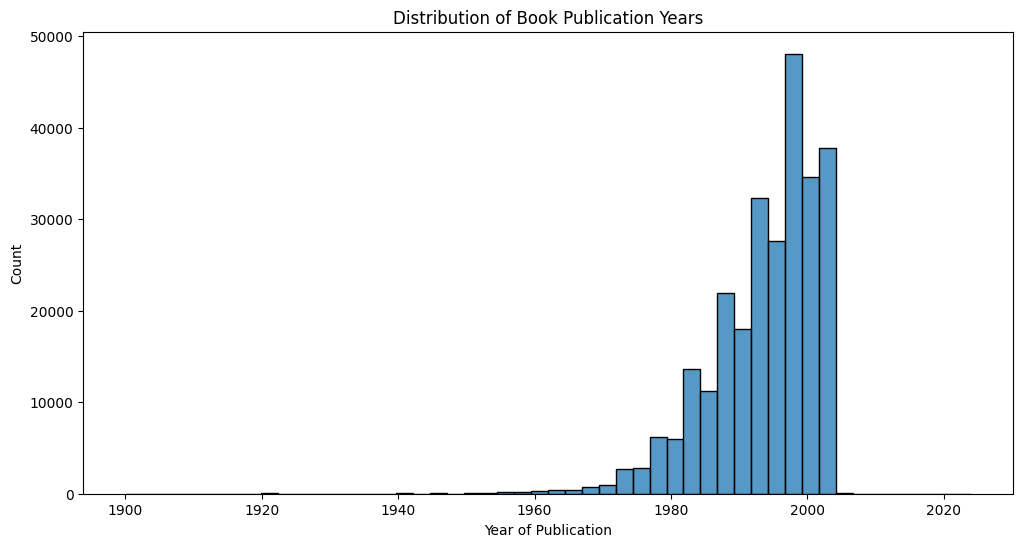

In [17]:
# Konversi Year-Of-Publication ke numeric (handle invalid values)
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# Filter tahun yang masuk akal (misalnya antara 1900-2025)
books = books[(books['Year-Of-Publication'] >= 1900) & (books['Year-Of-Publication'] <= 2025)]

# Plot distribusi tahun publikasi
plt.figure(figsize=(12,6))
sns.histplot(books['Year-Of-Publication'], bins=50)
plt.title('Distribution of Book Publication Years')
plt.xlabel('Year of Publication')
plt.ylabel('Count')
plt.show()

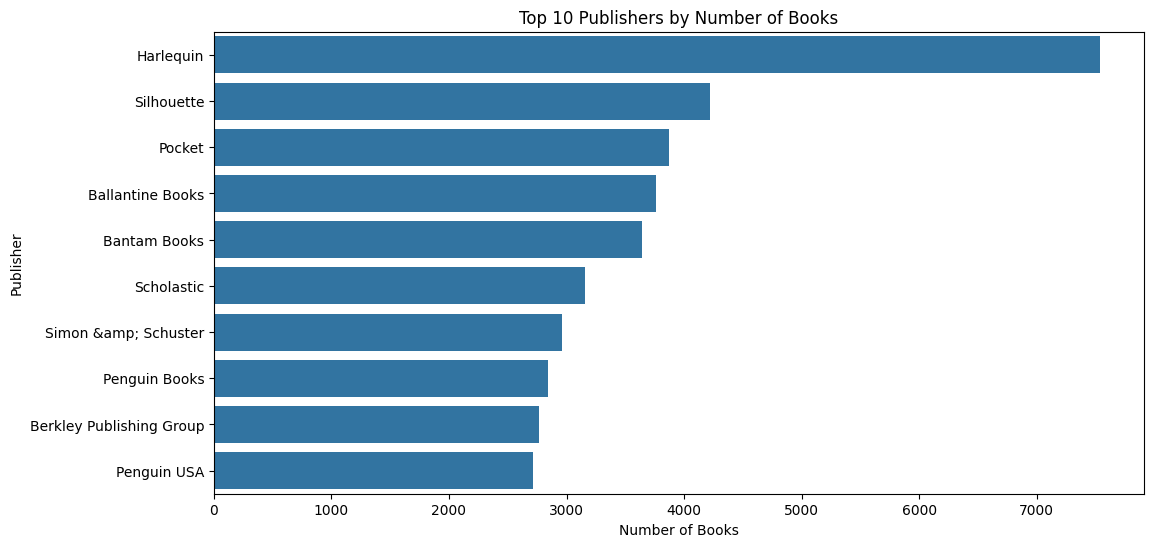

In [18]:
# Top 10 publisher dengan buku terbanyak
top_publishers = books['Publisher'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('Top 10 Publishers by Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Publisher')
plt.show()

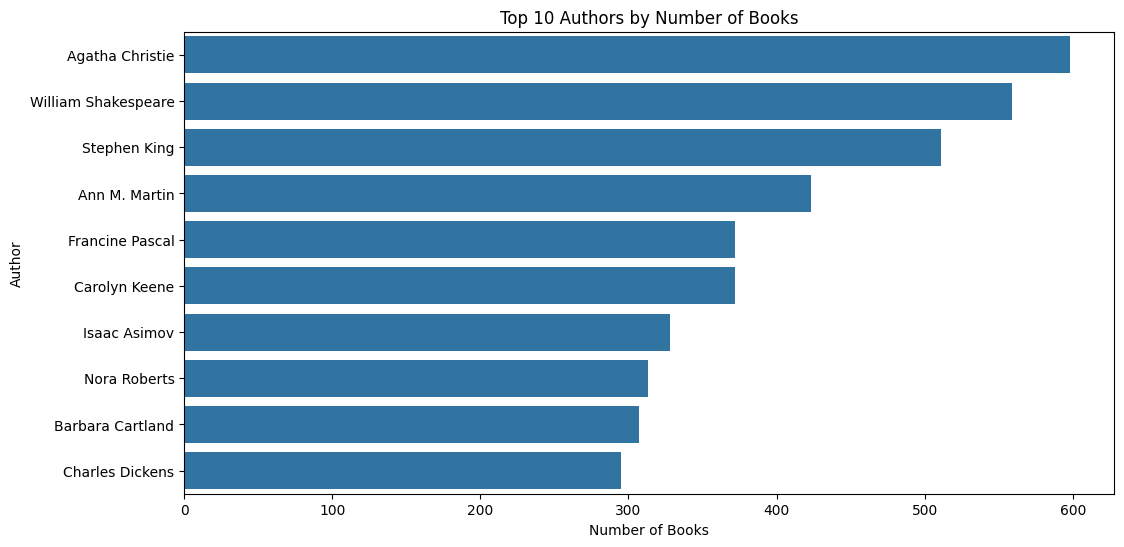

In [19]:
# Top 10 authors dengan buku terbanyak
top_authors = books['Book-Author'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title('Top 10 Authors by Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64


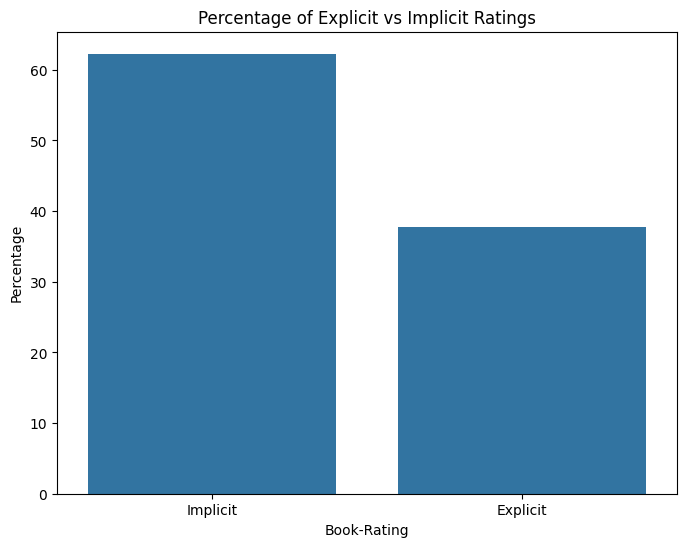

In [20]:
# Hitung statistik deskriptif rating
print(ratings['Book-Rating'].describe())

# Persentase rating eksplisit (rating > 0) vs implisit (rating = 0)
rating_types = ratings['Book-Rating'].apply(lambda x: 'Explicit' if x > 0 else 'Implicit').value_counts(normalize=True) * 100

plt.figure(figsize=(8,6))
sns.barplot(x=rating_types.index, y=rating_types.values)
plt.title('Percentage of Explicit vs Implicit Ratings')
plt.ylabel('Percentage')
plt.show()

### **Multivariate Analysis**

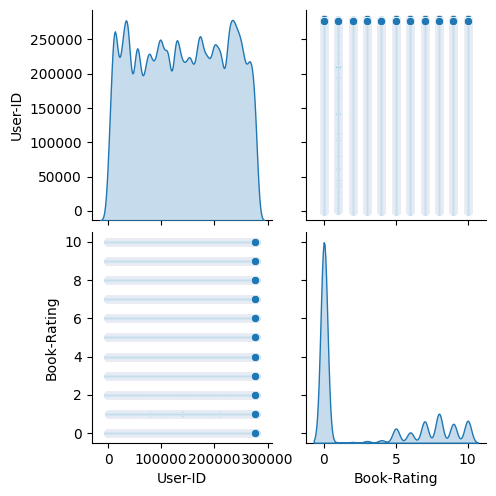

In [21]:
sns.pairplot(ratings, diag_kind = 'kde')

# **Data Preparation**

### **Mengatasi Missing Value dan Duplicated**

Apakah ada missing value atau tidak.

In [22]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0


Terdapat missing value di books.csv
- 2 entri penulis
- 2 entri penerbit
- 3 entri URL gambar (Large)

2-3 missing values dari total 270k entri (sangat kecil) → tidak signifikan secara statistik.

In [23]:
books.dropna(subset=['Book-Author', 'Publisher'], inplace=True)

In [24]:
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


Tidak terdapat missing value di ratings.csv

In [25]:
users.isnull().sum()

,0
User-ID,0
Location,0
Age,110762


Terdapat missing value di users.csv
- 110.762 entri usia  (bisa mencapai 40-60% dari total data).

Kita tidak menggunakan dataset users.csv karena:
- lebih dari 40% data usia tidak tersedia, sehingga tidak representatif.
- Tidak ada variabel pendukung lain (seperti gender atau preferensi) yang bisa membantu analisis berbasis usia.
- Tidak relevan untuk rekomendasi.

In [26]:
books.duplicated().sum()

np.int64(0)

In [27]:
ratings.duplicated().sum()

np.int64(0)

In [28]:
users.duplicated().sum()

np.int64(0)

Tidak terdapat data yang duplikat.

### **Content Based Filtering**

Memberi nama header baru pada kolom Book-Rating dan User-ID pada rating_dataset.

In [29]:
ratings = ratings.rename(columns={'Book-Rating': 'rating','User-ID':'user_id'})

Saya hanya mengambil 10000 row dari book dataset dan 5000 row untuk rating dataset.

In [30]:
books = books[:10000]
ratings =ratings[:5000]

In [31]:
ratings.head()

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Memberi nama header baru pada kolom Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M, Image-URL-L pada books.

In [32]:
books = books.rename(columns={'Book-Title': 'book_title','Book-Author':'book_author','Year-Of-Publication':'year_of_publication', 'Publisher':'publisher', 'Image-URL-S':'Image_URL_S','Image-URL-M':'Image_URL_M','Image-URL-L':'Image_URL_L'})

In [33]:
books.head()

,ISBN,book_title,book_author,year_of_publication,publisher,Image_URL_S,Image_URL_M,Image_URL_L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Men-drop seluruh row yang memiliki nilai NaN.

In [34]:
books = books.dropna()
ratings = ratings.dropna()

In [35]:
books.shape

(10000, 8)

In [36]:
ratings.shape

(5000, 3)

Mengubah dataframe dari buku menjadi sebuah list.

In [37]:
book_ISBN = books['ISBN'].tolist()

book_title = books['book_title'].tolist()

book_author = books['book_author'].tolist()

book_year_of_publication = books['year_of_publication'].tolist()

Setelah membuat list, kita perlu membuat dictionary yang digunakan untuk memnentukan pasangan key-value pada book_ISBN, book_title, book_author, dan book_year_of_publication.

In [38]:
book = pd.DataFrame({
    'book_ISBN': book_ISBN,
    'book_title': book_title,
    'book_author': book_author,
    'book_year_of_publication': book_year_of_publication
})
book

,book_ISBN,book_title,book_author,book_year_of_publication
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0
...,...,...,...,...
9995,0515101230,The Cat Who Went Underground,Lilian Jackson Braun,1991.0
9996,0515129941,The Cat Who Robbed a Bank (Cat Who... (Paperba...,Lilian Jackson Braun,2001.0
9997,0590421174,How Spider Saved Halloween,Robert Kraus,1988.0
9998,089919463X,The Teeny-Tiny Woman,Paul Galdone,1986.0


# **Modeling**

Pada content Based Filtering, kita akan menggunakan TF-IDF Vectorizer dan Cosine Similarity untuk membangun sistem rekomendasi.

### **TF-IDF Vectorizer**

In [39]:
tf = TfidfVectorizer()
tf.fit(book['book_title'])
print(tf.get_feature_names_out())

['00' '000' '003' ... 'â¼ter' 'â¼ttern' 'ã¼ber']


Lakukan fit dan transformasi ke dalam matriks, pada code di bawah ini, matriks tersebut adalah tfidf_matrix.

In [40]:
tfidf_matrix = tf.fit_transform(book['book_title'])

tfidf_matrix.shape

(10000, 11486)

Pada tfidf_matrix terdapat 10000 ukuran data dan 5586 nama penulis buku.

Mengubah tfidf_matrix yang awalnya vektor menjadi matriks.

In [41]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=book.book_title
).sample(10, axis=1,replace=True).sample(10, axis=0)

,littles,vice,insel,inverso,carnival,sunken,poirot,eld,serpents,ille
book_title,,,,,,,,,,
Cold Sassy Tree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Memory Book : A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Far Tortuga,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Siddhartha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Millroy the Magician,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fortune Is a River : Leonardo Da Vinci and Niccolo Machiavelli's Magnificent Dream to Change the Course of Florentine History,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Night Show,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Wild Bunch at Robbers Roost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Cosine Similarity**

Dalam sistem rekomendasi, kita perlu mencari cara supaya item yang kita rekomendasikan tidak terlalu jauh dari data pusat, oleh karena itu kita butuh derajat kesamaan pada item, dalam proyek ini, buku dengan derajat kesamaan antar buku dengan cosine similarity.

In [43]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.01732615],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01732615,
        1.        ]])

In [44]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=book['book_title'], columns=book['book_author'])
cosine_sim_df

book_author,Mark P. O. Morford,Richard Bruce Wright,Carlo D'Este,Gina Bari Kolata,E. J. W. Barber,Amy Tan,Robert Cowley,Scott Turow,David Cordingly,Ann Beattie,...,Ed Gorman,John Saul,John Saul,R. L. Stine,ELLEN DEGENERES,Lilian Jackson Braun,Lilian Jackson Braun,Robert Kraus,Paul Galdone,Jane B. Mason
book_title,,,,,,,,,,,,,,,,,,,,,
Classical Mythology,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Clara Callan,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Decision in Normandy,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,0.0,0.0,0.0,1.000000,0.074275,0.045328,0.019876,0.0,0.132725,0.022256,...,0.0,0.0,0.047419,0.019719,0.026126,0.036855,0.025495,0.0,0.037141,0.060771
The Mummies of Urumchi,0.0,0.0,0.0,0.074275,1.000000,0.023638,0.010365,0.0,0.071188,0.000000,...,0.0,0.0,0.024728,0.000000,0.000000,0.019219,0.013295,0.0,0.019368,0.018671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Cat Who Went Underground,0.0,0.0,0.0,0.036855,0.019219,0.021766,0.009544,0.0,0.045908,0.000000,...,0.0,0.0,0.022770,0.000000,0.000000,1.000000,0.443643,0.0,0.017835,0.017193
The Cat Who Robbed a Bank (Cat Who... (Paperback)),0.0,0.0,0.0,0.025495,0.013295,0.015057,0.006603,0.0,0.031758,0.000000,...,0.0,0.0,0.015752,0.000000,0.000000,0.443643,1.000000,0.0,0.012338,0.011894
How Spider Saved Halloween,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000


Di bawah ini adalah fungsi untuk mendapatkan rekomendasi berbasis penulis buku dengan k sebagai jumlah rekomendasi yang diingkan, dalam fungsi ini, kita akan mendapatkan 10 rekomendasi.

In [45]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = books.index[books['book_title'] == title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return books['book_title'].iloc[book_indices]

In [46]:
get_recommendations('Cradle and All')

,book_title
3898,The Gift
8465,MOTHER : MOTHER
10155,Myths of Motherhood: How Culture Reinvents the...
9160,Motherhood Is Murder
3959,A Gift To Last
2484,A Gift of Wings
1215,Gift From The Sea
5255,Gift from the Sea
1529,A Killing Gift
8692,Perfect Little Angels/Gift Book With 10 Noteca...


# **Evaluation**

In [47]:
# Definisi fungsi evaluasi
def precision_recall_at_k(recommended_items, relevant_items, k=10):
    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)

    true_positives = len([item for item in recommended_k if item in relevant_set])
    precision = true_positives / k
    recall = true_positives / len(relevant_set) if relevant_set else 0

    return precision, recall

In [48]:
# Misal user menyukai buku-buku ini:
relevant = ['The Gift', 'Motherhood Is Murder', 'Gift from the Sea']

# Dan sistem merekomendasikan:
recommended = ['The Gift', 'MOTHER : MOTHER', 'Myths of Motherhood',
               'Motherhood Is Murder', 'Gift From The Sea']

precision, recall = precision_recall_at_k(recommended, relevant, k=5)
print(f'Precision@5: {precision:.2f}')
print(f'Recall@5: {recall:.2f}')

Precision@5: 0.40
Recall@5: 0.67


Hasil evaluasi tersebut menunjukkan:

- Precision@5 = 0.40
Artinya: dari 5 buku yang direkomendasikan oleh sistem, 40% (2 buku) memang relevan atau disukai oleh pengguna.
→ Sistem merekomendasikan 5 buku, dan 2 di antaranya cocok.

- Recall@5 = 0.67
Artinya: dari seluruh buku yang disukai pengguna (3 buku), 67% (2 buku) berhasil ditemukan oleh sistem dalam 5 rekomendasi teratas.
→ Sistem berhasil menemukan 2 dari 3 buku relevan.

### **Collaborative Filtering**

Pada cell code di bawah ini, kita akan meyandikan user_id menjadi integer.

In [49]:
user_ids = ratings['user_id'].unique().tolist()

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

Pada cell code di bawah ini, saya akan meyandikan book_id menjadi integer.

In [50]:
book_ids = ratings['ISBN'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

ratings['user'] = ratings['user_id'].map(user_to_user_encoded)
ratings['book'] = ratings['ISBN'].map(book_to_book_encoded)

 Kita akan cek jumlah pengguna dan jumlah buku, serta mengubah tipe data rating menjadi float.

In [53]:
num_users = len(user_encoded_to_user)
print(num_users)
num_book = len(book_encoded_to_book)
print(num_book)
ratings['rating'] = ratings['rating'].values.astype(np.float32)

min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

print('Number of User: {}, Number of Book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

679
4688
Number of User: 679, Number of Book: 4688, Min Rating: 0.0, Max Rating: 10.0


### **Membagi Dataset**

Sebelum kita membagi dataset menjadi data latih dan data validasi, kita terlebih dahulu harus mengacak dataset.

In [54]:
rating_dataset = ratings.sample(frac=1, random_state=42)
rating_dataset

,user_id,ISBN,rating,user,book
1501,277427,0201000822,10.0,255,1470
2586,277639,0453008739,0.0,335,2487
2653,277639,0671509144,0.0,335,2550
1055,277187,0553281089,0.0,170,1041
705,276964,0886774829,8.0,96,696
...,...,...,...,...,...
4426,278418,0061091464,0.0,678,4127
466,276925,3775713328,0.0,80,461
3092,277928,0937247065,7.0,476,2935
3772,278159,0385318073,5.0,574,3549


Saya membagi dataset yang ada menjadi 70% untuk latihan dan 30% untuk validasi.

In [55]:
x = rating_dataset[['user', 'book']].values

y = rating_dataset['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.70 * rating_dataset.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 255 1470]
 [ 335 2487]
 [ 335 2550]
 ...
 [ 476 2935]
 [ 574 3549]
 [ 139  850]] [1.  0.  0.  ... 0.7 0.5 0.5]


# **Modeling**

Model yang akan kita pakai dalam sistem rekomendasi berbasis pendapat pengguna adalah RecommenderNet.

In [56]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [63]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.book_embedding = layers.Embedding(
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_book, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    book_vector = self.book_embedding(inputs[:, 1])
    book_bias = self.book_bias(inputs[:, 1])

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x)

Selanjutnya kita melakukan proses compile pada model dengan binary crossentropy sebagai loss function, adam sebagai optimizer, dan RMSE sebagai metrik dari model.

In [64]:
model = RecommenderNet(num_users, num_book, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [65]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 5,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6794 - root_mean_squared_error: 0.4268 - val_loss: 0.6412 - val_root_mean_squared_error: 0.4098
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5925 - root_mean_squared_error: 0.3753 - val_loss: 0.6111 - val_root_mean_squared_error: 0.3922
Epoch 3/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5283 - root_mean_squared_error: 0.3431 - val_loss: 0.5957 - val_root_mean_squared_error: 0.3836
Epoch 4/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5114 - root_mean_squared_error: 0.3332 - val_loss: 0.5812 - val_root_mean_squared_error: 0.3759
Epoch 5/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4792 - root_mean_squared_error: 0.3120 - val_loss: 0.5690 - val_root_mean_squared_error: 0.3698
Epoch 6/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4668 - root_mean_squared_error: 0.3039 - val_loss: 0.5598 - val_root_mean_squared_error: 0.3654
Epoch 7/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step 

# **Evaluation**

## **Visualisasi Metrik**

Berikut adalah hasil latihan dari data yang ada, evaluasi metrik yang digunakan adalah RMSE.

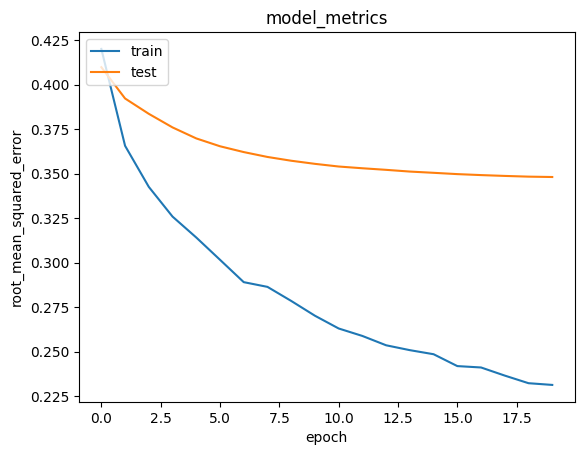

In [66]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Sebelumnya, kita perlu mendefinisikan ulang book_dataset dan rating_dataset.

In [67]:
book_dataset =  book
rating_dataset = rating_dataset

In [68]:
user_id = rating_dataset.user_id.sample(1).iloc[0]
books_have_been_read_by_user = rating_dataset[rating_dataset.user_id == user_id]

books_have_not_been_read_by_user = book_dataset[book_dataset['book_ISBN'].isin(books_have_been_read_by_user.ISBN.values)]['book_ISBN']
books_have_not_been_read_by_user = list(
    set(books_have_not_been_read_by_user)
    .intersection(set(book_to_book_encoded.keys()))
)

books_have_not_been_read_by_user = [[book_to_book_encoded.get(x)] for x in books_have_not_been_read_by_user]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(books_have_not_been_read_by_user), books_have_not_been_read_by_user)
)

In [69]:
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(books_have_not_been_read_by_user[x][0]) for x in top_ratings_indices
]

top_books_recommended = (
    books_have_been_read_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

books_row = book_dataset[book_dataset['book_ISBN'].isin(top_books_recommended)]
for row in books_row.itertuples():
    print(row.book_title, ':', row.book_author)

print('----' * 8)
print('Top 10 Book Recommendation for user: {}'.format(user_id))
print('----' * 8)

recommended_books = book_dataset[book_dataset['book_ISBN'].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(row.book_title, ':', row.book_author)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
Cold Sassy Tree : Olive Ann Burns
CRY THE BELOVED COUNTRY (Scribner Classic) : Alan Paton
Mutant Message Down Under : Marlo Morgan
The Magic Circle : Katherine Neville
Ahab's Wife: Or, The Star-Gazer: A Novel : Sena Jeter Naslund
--------------------------------
Top 10 Book Recommendation for user: 278194
--------------------------------
Cold Sassy Tree : Olive Ann Burns
The King of Torts : JOHN GRISHAM
The Temple of My Familiar : Alice Walker
East of the Mountains (Vintage Contemporaries (Paperback)) : David Guterson
Mutant Message Down Under : Marlo Morgan
Tulip Fever : DEBORAH MOGGACH
The Magic Circle : Katherine Neville
Truly, Madly Manhattan : Nora Roberts
The Virgin Blue : Tracy Chevalier
Ahab's Wife: Or, The Star-Gazer: A Novel : Sena Jeter Naslund
